In [2]:
# Read in SF crime data
crime = pd.read_csv('~/Desktop/project1030/SF/SF.csv')
print(crime.shape)

(878049, 9)


In [3]:
# Create date variable from datetime
crime['datetime'] = pd.to_datetime(crime['Dates'])
dates_only = crime['datetime'].map(pd.Timestamp.date)
print(dates_only[0:5])
crime['date'] = dates_only

0    2015-05-13
1    2015-05-13
2    2015-05-13
3    2015-05-13
4    2015-05-13
Name: datetime, dtype: object


In [4]:
# Extract years, months, and times
years_only = crime['datetime'].map(lambda t: t.year)
crime['year'] = years_only
print(crime['year'].head())

time_only = crime['datetime'].map(lambda t: t.time)
crime['time'] = time_only
print(crime['time'].head())

months_only = crime['datetime'].map(lambda t: t.month)
crime['month'] = months_only
print(crime['month'].head())

0    2015
1    2015
2    2015
3    2015
4    2015
Name: year, dtype: int64
0    <built-in method time of Timestamp object at 0...
1    <built-in method time of Timestamp object at 0...
2    <built-in method time of Timestamp object at 0...
3    <built-in method time of Timestamp object at 0...
4    <built-in method time of Timestamp object at 0...
Name: time, dtype: object
0    5
1    5
2    5
3    5
4    5
Name: month, dtype: int64


In [5]:
# To simplify initially, keep only crime reports from 2003 to 2005
#crime_new = crime[crime['year'].isin([2003, 2004, 2005])]

# Confusing, but I kept this because I didn't want to change future references to "crime_new"
crime_new = crime

In [6]:
print(crime_new.shape)
print(crime_new['year'].value_counts())

(878049, 14)
2013    75606
2014    74766
2003    73902
2004    73422
2012    71731
2005    70779
2008    70174
2006    69909
2009    69000
2007    68015
2011    66619
2010    66542
2015    27584
Name: year, dtype: int64


In [7]:
# Sort by date
crime_new.sort_values('datetime', inplace=True)
#print(crime_new['datetime'].tail(10))

Now we want to import the census tract boundaries information and create an variable indicating in which census tract each crime occurred.

In [8]:
import geopandas as gpd
import os

# Read in csv file containing SF census tracts and corresponding MULTIPOLYGON objects
data_path = '/Users/Sam/Desktop/project1030/SF'
census_tr = pd.read_csv(os.path.join(data_path, 'Census_2010_Tracts.csv'))

In [9]:
from geopandas import GeoDataFrame
import shapely.wkt

geometry = census_tr['the_geom'].map(shapely.wkt.loads)
print(census_tr.head())

crs = {'init': 'epsg:4326'}

# Restrict to mainland SF 
census_tr = census_tr[census_tr['INTPTLON10'] > -122.6]

sf_census_tracts = GeoDataFrame(census_tr, crs=crs, geometry=geometry)

   STATEFP10  TRACTCE10                                           the_geom  \
0          6      16500  MULTIPOLYGON (((-122.446471 37.775802, -122.44...   
1          6      16400  MULTIPOLYGON (((-122.44033999999999 37.7765799...   
2          6      16300  MULTIPOLYGON (((-122.429152 37.778006999999995...   
3          6      16100  MULTIPOLYGON (((-122.428909 37.778039, -122.42...   
4          6      16000  MULTIPOLYGON (((-122.420425 37.780583, -122.42...   

   COUNTYFP10     GEOID10  NAME10        NAMELSAD10 MTFCC10 FUNCSTAT10  \
0          75  6075016500   165.0  Census Tract 165   G5020          S   
1          75  6075016400   164.0  Census Tract 164   G5020          S   
2          75  6075016300   163.0  Census Tract 163   G5020          S   
3          75  6075016100   161.0  Census Tract 161   G5020          S   
4          75  6075016000   160.0  Census Tract 160   G5020          S   

   ALAND10  AWATER10  INTPTLAT10  INTPTLON10  
0   370459         0   37.774196 -122.4

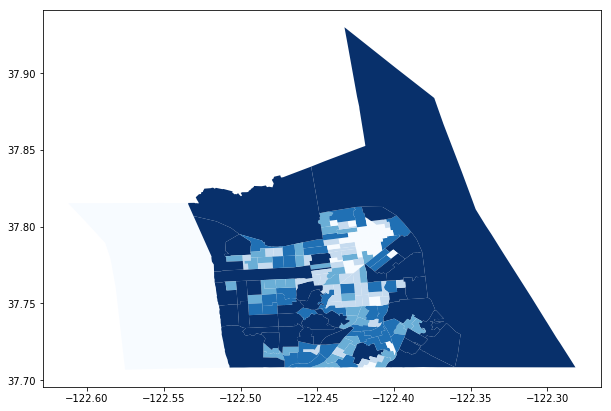

In [19]:
# Plot census tracts
sf_census_tracts[sf_census_tracts['AWATER10'] == 0]
sf_census_tracts.plot(figsize=(10, 20), column='ALAND10', cmap='Blues', scheme='quantiles')
plt.show()

Idea: for every crime, loop over all census tract polygons, and see which one contains it. Create a new variable containing the census tract #

In [11]:
from shapely.geometry import Point

# First convert all crime occurrences to Point objects
crime_locs = [Point(xy) for xy in zip(crime_new['X'], crime_new['Y'])]
crime_locs_df = GeoDataFrame(crime_locs, crs=crs, geometry=crime_locs)

In [12]:
# Add locations to original dataframe
crime_new['locs'] = crime_locs

In [13]:
# Execute spatial join of crimes with census tract boundaries 
crime_census = gpd.sjoin(crime_locs_df, sf_census_tracts, how="inner", op='within')

In [14]:
print(crime_census.columns)

# NAME10 is the column from the census tracts dataset with the numeric identifier
# How many crimes happened in each census tract?
print(crime_census['NAME10'].value_counts())
print(crime_census.shape)

Index([            0,    'geometry', 'index_right',   'STATEFP10',
         'TRACTCE10',    'the_geom',  'COUNTYFP10',     'GEOID10',
            'NAME10',  'NAMELSAD10',     'MTFCC10',  'FUNCSTAT10',
           'ALAND10',    'AWATER10',  'INTPTLAT10',  'INTPTLON10'],
      dtype='object')
176.01     44398
180.00     37512
201.00     24937
125.01     24913
117.00     24562
615.00     24102
124.02     19914
177.00     14921
124.01     14475
178.02     14446
125.02     13782
208.00     13322
123.01     12888
612.00     12009
101.00     11595
166.00      9745
209.00      9398
9809.00     9023
122.02      9011
228.01      8602
122.01      8542
9803.00     8527
232.00      8309
120.00      7836
161.00      7769
111.00      7645
614.00      7432
231.03      7404
228.02      7377
105.00      7205
           ...  
260.02      1410
156.00      1409
301.02      1403
129.01      1395
264.04      1393
258.00      1392
263.03      1372
305.00      1362
171.01      1332
426.02      1315
328.02      

In [15]:
print(crime_census.head())

                                              0  \
0     POINT (-122.394925721424 37.738211541052)   
197  POINT (-122.39510178235 37.74838969908871)   
388   POINT (-122.402868034989 37.749478392917)   
445  POINT (-122.399679574042 37.7494852273741)   
462  POINT (-122.405242467123 37.7430506903432)   

                                       geometry  index_right  STATEFP10  \
0     POINT (-122.394925721424 37.738211541052)           40          6   
197  POINT (-122.39510178235 37.74838969908871)           40          6   
388   POINT (-122.402868034989 37.749478392917)           40          6   
445  POINT (-122.399679574042 37.7494852273741)           40          6   
462  POINT (-122.405242467123 37.7430506903432)           40          6   

     TRACTCE10                                           the_geom  COUNTYFP10  \
0       980900  MULTIPOLYGON (((-122.37411699999998 37.744975,...          75   
197     980900  MULTIPOLYGON (((-122.37411699999998 37.744975,...          75   

In [16]:
# Extract X and Y coordinates
x_coords = crime_census['geometry'].apply(lambda p: p.x)
y_coords = crime_census['geometry'].apply(lambda p: p.y)

# Create new truncated df containing only Point object and census tract name
crime_census_trunc = crime_census[['NAME10', 'the_geom']]
crime_census_trunc['X'] = x_coords
crime_census_trunc['Y'] = y_coords

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
print(crime_census_trunc.shape)
print(crime_new.shape)

# Remove duplicates from spatially merged dataset (crime_census_trunc)
crime_census_trunc.drop_duplicates(inplace=True)
print(crime_census_trunc.shape)

(877826, 4)
(878049, 15)
(34222, 4)


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [18]:
# Now, merge on census tract information to crime_new dataset, joining on the coordinate variables
crime_merged = pd.merge(crime_new, crime_census_trunc, how='inner', on=['X', 'Y'])

In [19]:
print(crime_merged.shape)

(877826, 17)


In [20]:
crime_merged.rename(columns= {'NAME10': 'census_tr', 'the_geom': 'census_tr_poly'}, inplace=True)

In [21]:
# Export original crime data with census tract information
#crime_merged.to_csv('~/Desktop/project1030/SF/crime_with_census_tracts.csv', index=False)

In [22]:
print(crime_merged.tail())

                      Dates       Category  \
877821  2015-05-11 17:35:00  LARCENY/THEFT   
877822  2015-05-11 21:30:00  LARCENY/THEFT   
877823  2015-05-13 02:00:00  VEHICLE THEFT   
877824  2015-05-13 13:00:00       BURGLARY   
877825  2015-05-13 19:00:00  LARCENY/THEFT   

                                     Descript  DayOfWeek PdDistrict  \
877821           GRAND THEFT FROM LOCKED AUTO     Monday    TARAVAL   
877822         GRAND THEFT FROM UNLOCKED AUTO     Monday    TARAVAL   
877823                      STOLEN AUTOMOBILE  Wednesday    TARAVAL   
877824  BURGLARY OF RESIDENCE, FORCIBLE ENTRY  Wednesday  INGLESIDE   
877825           GRAND THEFT FROM LOCKED AUTO  Wednesday    BAYVIEW   

       Resolution                    Address           X          Y  \
877821       NONE         8TH AV / MORAGA ST -122.464719  37.756630   
877822       NONE      1700 Block of 36TH AV -122.494824  37.754348   
877823       NONE        47TH AV / ORTEGA ST -122.506347  37.751050   
877824      

We want to create features based on crime history. Therefore, we need a way to count the number of specific crimes that occurred within the last 1-5 hours, 1-3, 7, and 14 days. As a starting point, create a very small dataset and experiment with calculating differences in datetime variables:

In [23]:
# Start off by creating a smaller (n=50) dataset and trying to count prior crimes
crime_test = crime_merged.sort_values(by='datetime').head(50)
print(crime_test.shape)

(50, 17)


In [24]:
# Keep only relevant vars
crime_test = crime_test[['Dates', 'Category', 'DayOfWeek', 'date', 'year', 'time', 'month']]
#print(crime_test.head(20))

In [25]:
crime_test['datetime'] = pd.to_datetime(crime_test['Dates'])
crime_test['day'] = crime_test['datetime'].apply(lambda d: d.day)
crime_test['hour'] = crime_test['datetime'].apply(lambda d: d.hour)
crime_test['minute'] = crime_test['datetime'].apply(lambda d: d.minute)
#print(crime_test.head(20))

In [26]:
# Test case: can we get the number of minutes between two datetime stamps?
delta = crime_test['datetime'].values[20] - crime_test['datetime'].values[1]
mins = delta.astype('timedelta64[m]')
mins / np.timedelta64(1, 'm')

119.0

In [27]:
# Function to calculate difference between two datetimes: datetime_2 (later) and datetime_init (earlier)
def calc_time_delta(datetime_2, datetime_init):
    delta = datetime_2 - datetime_init
    print(type(delta))
    mins = delta.astype('timedelta64[m]')
    return(mins / np.timedelta64(1, 'm'))

# Map this function over the entire datetime column to get minutes elapsed since beginning
# of dataset
#crime_test['min_elapsed'] = np.apply_along_axis(func1d = calc_time_delta, axis = 0, \
#                            arr=crime_test['datetime'].values, datetime_init=crime_test['datetime'].values[0])

Now that we understand how to slice by time window, return to the (complete) crime_merged dataset and create features we will need in our model.

In [28]:
#print(crime_merged.columns)

# Crime dataset with unneccesary features removed where we will engineer new features
crime_engin_temp = crime_merged[['Category', 'DayOfWeek', 'datetime', 'date', 'year', \
                            'time', 'month', 'census_tr']]

# Add eviction-specific columns (all zeros for crime observations)
crime_engin_temp['non_payment'] = 0
crime_engin_temp['illegal_use'] = 0
crime_engin_temp['eviction'] = 0

print(crime_engin_temp.head())

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


                 Category DayOfWeek            datetime        date  year  \
0  FORGERY/COUNTERFEITING    Monday 2003-01-06 00:01:00  2003-01-06  2003   
1           LARCENY/THEFT    Monday 2003-01-06 00:01:00  2003-01-06  2003   
2            NON-CRIMINAL    Sunday 2005-07-17 12:00:00  2005-07-17  2005   
3               VANDALISM    Monday 2003-01-06 00:01:00  2003-01-06  2003   
4           LARCENY/THEFT  Saturday 2003-01-25 12:00:00  2003-01-25  2003   

                                                time  month  census_tr  \
0  <built-in method time of Timestamp object at 0...      1     9809.0   
1  <built-in method time of Timestamp object at 0...      1      311.0   
2  <built-in method time of Timestamp object at 0...      7      311.0   
3  <built-in method time of Timestamp object at 0...      1      615.0   
4  <built-in method time of Timestamp object at 0...      1      615.0   

   non_payment  illegal_use  eviction  
0            0            0         0  
1           

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [29]:
# Read in processed eviction data
evict = pd.read_csv('~/Desktop/project1030/SF/evict_processed.csv')
print(evict.head())

evict.drop(columns=['datetime'], inplace=True)

# Convert date to datetime
def date_to_datetime(date):
    #return str(date)
    return pd.to_datetime(str(date))

#date_to_datetime(evict['date'].values[0])
evict['datetime'] = evict['date'].apply(lambda x: date_to_datetime(x))

         date  census_tr  non_payment  illegal_use  eviction    datetime  \
0  2003-01-02     158.02            0            0         1  2003-01-02   
1  2003-01-02     228.01            0            0         1  2003-01-02   
2  2003-01-02     302.02            0            0         1  2003-01-02   
3  2003-01-02     232.00            0            0         1  2003-01-02   
4  2003-01-03     204.01            0            0         1  2003-01-03   

                                                time  Category  year  month  \
0  <built-in method time of Timestamp object at 0...  EVICTION  2003      1   
1  <built-in method time of Timestamp object at 0...  EVICTION  2003      1   
2  <built-in method time of Timestamp object at 0...  EVICTION  2003      1   
3  <built-in method time of Timestamp object at 0...  EVICTION  2003      1   
4  <built-in method time of Timestamp object at 0...  EVICTION  2003      1   

   DayOfWeek  
0        NaN  
1        NaN  
2        NaN  
3       

In [30]:
crime_engin = crime_engin_temp.append(evict).sort_values(by='datetime')
print(crime_engin.shape)

(896440, 11)


In [31]:
#print(crime_engin[['Category', 'datetime']].head(450))

In [32]:
# Two functions that simply define property and violent crimes based on Category variable
def is_property_crime(crime_type):
    return (crime_type in ['BURGLARY', 'LARCENY/THEFT', 'VEHICLE THEFT', 'RECOVERED VEHICLE', \
                      'ARSON', 'VANDALISM', 'STOLEN PROPERTY', 'EMBEZZLEMENT'])

def is_violent_crime(crime_type):
    return (crime_type in ['ASSAULT', 'SEX OFFENSES FORCIBLE', 'KIDNAPPING'])

In [33]:
import warnings
warnings.filterwarnings('ignore')

# Create categorical variables for crimes by mapping above functions over Category column
crime_engin['property_crime'] = crime_engin['Category'].apply(is_property_crime).astype(int)
crime_engin['violent_crime'] = crime_engin['Category'].apply(is_violent_crime).astype(int)

crime_engin['robbery'] = (crime_engin['Category'] == 'ROBBERY').astype(int)

crime_engin['other_crime'] = crime_engin['property_crime'] + crime_engin['violent_crime'] + crime_engin['robbery'] + 1
crime_engin['other_crime'].replace(2, 0, inplace=True)

crime_engin['any_crime'] = crime_engin['property_crime'] + crime_engin['violent_crime'] + \
                            crime_engin['robbery'] + crime_engin['other_crime']

# The total for any row should be 1 (has to fall into one of the categories!)
assert(crime_engin['any_crime'].unique() == 1)

#print(crime_engin[['property_crime', 'violent_crime', 'robbery', 'other_crime', 'Category']].head(20))

In [34]:
# Make sure variables were created correctly
#print(crime_engin[crime_engin['robbery'] == 1].head())

In [35]:
# Day of week, dummied out
crime_engin['dow_1'] = (crime_engin['DayOfWeek'] == 'Monday').astype(int)
crime_engin['dow_2'] = (crime_engin['DayOfWeek'] == 'Tuesday').astype(int)
crime_engin['dow_3'] = (crime_engin['DayOfWeek'] == 'Wednesday').astype(int)
crime_engin['dow_4'] = (crime_engin['DayOfWeek'] == 'Thursday').astype(int)
crime_engin['dow_5'] = (crime_engin['DayOfWeek'] == 'Friday').astype(int)
crime_engin['dow_6'] = (crime_engin['DayOfWeek'] == 'Saturday').astype(int)
crime_engin['dow_7'] = (crime_engin['DayOfWeek'] == 'Sunday').astype(int)

# Month
crime_engin['month_1'] = (crime_engin['month'] == 1).astype(int)
crime_engin['month_2'] = (crime_engin['month'] == 2).astype(int)
crime_engin['month_3'] = (crime_engin['month'] == 3).astype(int)
crime_engin['month_4'] = (crime_engin['month'] == 4).astype(int)
crime_engin['month_5'] = (crime_engin['month'] == 5).astype(int)
crime_engin['month_6'] = (crime_engin['month'] == 6).astype(int)
crime_engin['month_7'] = (crime_engin['month'] == 7).astype(int)
crime_engin['month_8'] = (crime_engin['month'] == 8).astype(int)
crime_engin['month_9'] = (crime_engin['month'] == 9).astype(int)
crime_engin['month_10'] = (crime_engin['month'] == 10).astype(int)
crime_engin['month_11'] = (crime_engin['month'] == 11).astype(int)
crime_engin['month_12'] = (crime_engin['month'] == 12).astype(int)

# Year
crime_engin['year_2003'] = (crime_engin['year'] == 2003).astype(int)
crime_engin['year_2004'] = (crime_engin['year'] == 2004).astype(int)
crime_engin['year_2005'] = (crime_engin['year'] == 2005).astype(int)
crime_engin['year_2006'] = (crime_engin['year'] == 2006).astype(int)
crime_engin['year_2007'] = (crime_engin['year'] == 2007).astype(int)
crime_engin['year_2008'] = (crime_engin['year'] == 2008).astype(int)
crime_engin['year_2009'] = (crime_engin['year'] == 2009).astype(int)
crime_engin['year_2010'] = (crime_engin['year'] == 2010).astype(int)
crime_engin['year_2011'] = (crime_engin['year'] == 2011).astype(int)
crime_engin['year_2012'] = (crime_engin['year'] == 2012).astype(int)
crime_engin['year_2013'] = (crime_engin['year'] == 2013).astype(int)
crime_engin['year_2014'] = (crime_engin['year'] == 2014).astype(int)
crime_engin['year_2015'] = (crime_engin['year'] == 2015).astype(int)

In [36]:
# Extract hour from datetime
hours_only = crime['datetime'].map(lambda t: t.hour)
crime_engin['hour'] = hours_only

In [37]:
# Hour binary variables 
crime_engin['hour_1'] = (crime_engin['hour'] == 1).astype(int)
crime_engin['hour_2'] = (crime_engin['hour'] == 2).astype(int)
crime_engin['hour_3'] = (crime_engin['hour'] == 3).astype(int)
crime_engin['hour_4'] = (crime_engin['hour'] == 4).astype(int)
crime_engin['hour_5'] = (crime_engin['hour'] == 5).astype(int)
crime_engin['hour_6'] = (crime_engin['hour'] == 6).astype(int)
crime_engin['hour_7'] = (crime_engin['hour'] == 7).astype(int)
crime_engin['hour_8'] = (crime_engin['hour'] == 8).astype(int)
crime_engin['hour_9'] = (crime_engin['hour'] == 9).astype(int)
crime_engin['hour_10'] = (crime_engin['hour'] == 10).astype(int)
crime_engin['hour_11'] = (crime_engin['hour'] == 11).astype(int)
crime_engin['hour_12'] = (crime_engin['hour'] == 12).astype(int)
crime_engin['hour_13'] = (crime_engin['hour'] == 13).astype(int)
crime_engin['hour_14'] = (crime_engin['hour'] == 14).astype(int)
crime_engin['hour_15'] = (crime_engin['hour'] == 15).astype(int)
crime_engin['hour_16'] = (crime_engin['hour'] == 16).astype(int)
crime_engin['hour_17'] = (crime_engin['hour'] == 17).astype(int)
crime_engin['hour_18'] = (crime_engin['hour'] == 18).astype(int)
crime_engin['hour_19'] = (crime_engin['hour'] == 19).astype(int)
crime_engin['hour_20'] = (crime_engin['hour'] == 20).astype(int)
crime_engin['hour_21'] = (crime_engin['hour'] == 21).astype(int)
crime_engin['hour_22'] = (crime_engin['hour'] == 22).astype(int)
crime_engin['hour_23'] = (crime_engin['hour'] == 23).astype(int)
crime_engin['hour_24'] = (crime_engin['hour'] == 24).astype(int)

Try out functions for creating prior crime variables on smaller test dataset

In [38]:
# Create time index = minutes elapsed since beginning of data
crime_engin['min_elapsed'] = np.apply_along_axis(func1d = calc_time_delta, axis = 0, \
                             arr=crime_engin['datetime'].values, datetime_init=crime_engin['datetime'].values[0])

<class 'numpy.ndarray'>


In [39]:
# Start date = 1/6/2003, 01:00

# CRITICAL STEP: this is where we decide how much of the DF to slice. We always will drop the first ~3000 obs., because
# they correspond to two weeks of observations and therefore our prior_2_week variables will be meaningless
# for these observations 
crime_engin_temp = crime_engin.sort_values(by='datetime')

print(crime_engin_temp.shape)

(896440, 74)


In [40]:
# Set indices for crime_engin2, AND temporarily shrink crime_engin as well to make it run faster
crime_engin2 = crime_engin_temp.iloc[200000:250000]
crime_engin = crime_engin_temp.iloc[196500:250100]

print(crime_engin.shape)
print(crime_engin2.shape)
print(crime_engin['datetime'].head(1))
print(crime_engin2['datetime'].head(1))
print(crime_engin2['datetime'].tail(1))
print(crime_engin['datetime'].tail(1))

# Remove evictions from crime_engin2 (what we're getting counts for) because crime_engin will have these 
# counts (only want these counts for crimes)
print(crime_engin2.shape)
crime_engin2 = crime_engin2[crime_engin2['Category'] != 'EVICTION']
print(crime_engin2.shape)

(53600, 74)
(50000, 74)
72488   2005-08-26 05:40:00
Name: datetime, dtype: datetime64[ns]
515062   2005-09-11 04:00:00
Name: datetime, dtype: datetime64[ns]
785206   2006-05-20 20:00:00
Name: datetime, dtype: datetime64[ns]
621617   2006-05-21 00:03:00
Name: datetime, dtype: datetime64[ns]
(50000, 74)
(49004, 74)


In [41]:
# Combine slice and sum functions
def return_sum_over_slice(df, start_time, time_window, census_tract):
    
    if (start_time-time_window) >= 0:
        sliced_df = df[(df['min_elapsed'] < start_time) & (df['min_elapsed'] >= (start_time-time_window))]
        
    else:
        sliced_df = df[(df['min_elapsed'] < start_time)]
        
    # Restrict only to crimes in that census tract
    result = sliced_df[sliced_df['census_tr'] == census_tract]
    
    if (result.empty==False):
        return (result['property_crime'].sum(), result['violent_crime'].sum(), result['robbery'].sum(), \
                result['other_crime'].sum(), result['any_crime'].sum(), result['non_payment'].sum(), \
                result['illegal_use'].sum(), result['eviction'].sum())
    else:
        return (0, 0, 0, 0, 0, 0, 0, 0)

In [42]:
# Function to convert counts to binary (only using for future crimes as of now)
def convert_to_binary(val):
    return min(val, 1)

# Test cases
print(convert_to_binary(0))
print(convert_to_binary(1))
print(convert_to_binary(5))

0
1
1


In order to calculate prior crimes for a given observation (n), we need to pass in parameters that don't vary for each row (df, time_window, var) as well as parameters that do vary by row (start_time = min_elapsed[n], census_tract=census_tr[n]). Create a new column to contain these two varying parameters in a tuple, then use a lambda function to iterate over the rows

In [43]:
crime_engin2['start_and_census'] = list(zip(crime_engin2['min_elapsed'], crime_engin2['census_tr']))

In [44]:
import time 
start = time.time()

# Past crimes
df_1_hour = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=60.0, census_tract = x[1])[0:5], crime_engin2['start_and_census'])])

df_2_hours = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=120.0, census_tract = x[1])[0:5], crime_engin2['start_and_census'])])

df_3_hours = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=180.0, census_tract = x[1])[0:5], crime_engin2['start_and_census'])])

df_4_hours = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=240.0, census_tract = x[1])[0:5], crime_engin2['start_and_census'])])

df_5_hours = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=300.0, census_tract = x[1])[0:5], crime_engin2['start_and_census'])])

df_1_day = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=1440.0, census_tract = x[1]), crime_engin2['start_and_census'])])

df_2_days = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=2880.0, census_tract = x[1]), crime_engin2['start_and_census'])])

df_3_days = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=4320.0, census_tract = x[1]), crime_engin2['start_and_census'])])

df_7_days = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=10080.0, census_tract = x[1]), crime_engin2['start_and_census'])])

df_14_days = pd.DataFrame([x for x in map(lambda x: return_sum_over_slice(df=crime_engin, start_time=x[0], time_window=20160.0, census_tract = x[1]), crime_engin2['start_and_census'])])

# Give names to columns
df_1_hour.columns = ['property_last_1_hour', 'violent_last_1_hour', 'robbery_last_1_hour', 'other_last_1_hour', 'any_last_1_hour']
df_2_hours.columns = ['property_last_2_hours', 'violent_last_2_hours', 'robbery_last_2_hours', 'other_last_2_hours', 'any_last_2_hours']
df_3_hours.columns = ['property_last_3_hours', 'violent_last_3_hours', 'robbery_last_3_hours', 'other_last_3_hours', 'any_last_3_hours']
df_4_hours.columns = ['property_last_4_hours', 'violent_last_4_hours', 'robbery_last_4_hours', 'other_last_4_hours', 'any_last_4_hours']
df_5_hours.columns = ['property_last_5_hours', 'violent_last_5_hours', 'robbery_last_5_hours', 'other_last_5_hours', 'any_last_5_hours']
df_1_day.columns = ['property_last_1_day', 'violent_last_1_day', 'robbery_last_1_day', 'other_last_1_day', 'any_last_1_day', 'nonpay_last_1_day', 'illegal_last_1_day', 'evict_last_1_day']
df_2_days.columns = ['property_last_2_days', 'violent_last_2_days', 'robbery_last_2_days', 'other_last_2_days', 'any_last_2_days', 'nonpay_last_2_days', 'illegal_last_2_days', 'evict_last_2_days']
df_3_days.columns = ['property_last_3_days', 'violent_last_3_days', 'robbery_last_3_days', 'other_last_3_days', 'any_last_3_days', 'nonpay_last_3_days', 'illegal_last_3_days', 'evict_last_3_days']
df_7_days.columns = ['property_last_7_days', 'violent_last_7_days', 'robbery_last_7_days', 'other_last_7_days', 'any_last_7_days', 'nonpay_last_7_days', 'illegal_last_7_days', 'evict_last_7_days']
df_14_days.columns = ['property_last_14_days', 'violent_last_14_days', 'robbery_last_14_days', 'other_last_14_days', 'any_last_14_days', 'nonpay_last_14_days', 'illegal_last_14_days', 'evict_last_14_days']

end = time.time()
print("Time to run:", end-start, "seconds")

KeyboardInterrupt: 

In [ ]:
start = time.time()

crime_engin2['future_property_1_hour'] = [convert_to_binary(x) for x in map(lambda x: return_sum_over_slice(df=crime_engin, \
                                        start_time=(x[0] + 60.0), time_window=59.99, \
                                        census_tract = x[1])[0], crime_engin2['start_and_census'])]

crime_engin2['future_violent_1_hour'] = [convert_to_binary(x) for x in map(lambda x: return_sum_over_slice(df=crime_engin, \
                                        start_time=(x[0] + 60.0), time_window=59.99, \
                                        census_tract = x[1])[1], crime_engin2['start_and_census'])]

crime_engin2['future_robbery_1_hour'] = [convert_to_binary(x) for x in map(lambda x: return_sum_over_slice(df=crime_engin, \
                                        start_time=(x[0] + 60.0), time_window=59.99, \
                                        census_tract = x[1])[2], crime_engin2['start_and_census'])]

crime_engin2['future_other_1_hour'] = [convert_to_binary(x) for x in map(lambda x: return_sum_over_slice(df=crime_engin, \
                                        start_time=(x[0] + 60.0), time_window=59.99, \
                                        census_tract = x[1])[3], crime_engin2['start_and_census'])]

crime_engin2['future_any_1_hour'] = [convert_to_binary(x) for x in map(lambda x: return_sum_over_slice(df=crime_engin, \
                                        start_time=(x[0] + 60.0), time_window=59.99, \
                                        census_tract = x[1])[4], crime_engin2['start_and_census'])]

end = time.time()
print("Time to run:", end-start, "seconds")

In [ ]:
# Merge on new features 
crime_engin2.reset_index(inplace=True, drop=True)
crime_concat = pd.concat([crime_engin2, df_1_hour, df_2_hours, df_3_hours, df_4_hours, df_5_hours, \
                          df_1_day, df_2_days, df_3_days, df_7_days, df_14_days], axis=1)

In [ ]:
print(crime_engin2.shape)
print(crime_concat.shape)
#print(list(crime_engin2))
print(list(crime_concat))

First idea for classifier: Build a neural network that predicts whether a crime will happen based on features. In order to do that, create a "crime occurred in the future in that census tract" indicator at a certain timescale (try 6 hours to start). The algorithm will learn to classify this label on the training data, and hopefully will also accurately predict on the test (held-out) data.

In [ ]:
print(crime_concat['future_any_1_hour'].head(25))

In [ ]:
print(crime_concat['future_property_1_hour'].value_counts())
print(crime_concat['future_violent_1_hour'].value_counts())
print(crime_concat['future_robbery_1_hour'].value_counts())
print(crime_concat['future_other_1_hour'].value_counts())
print(crime_concat['future_any_1_hour'].value_counts())

In [ ]:
print(list(crime_concat))

In [ ]:
# Value counts for eviction variables
print(crime_concat['evict_last_7_days'].value_counts())
print(crime_concat['nonpay_last_7_days'].value_counts())
print(crime_concat['illegal_last_7_days'].value_counts())

In [ ]:
# One hot encode census tracts
#print(len(crime_engin2['census_tr'].unique()))
census_one_hot = pd.get_dummies(crime_concat['census_tr'], prefix='ct')
crime_engin3 = pd.concat([crime_concat, census_one_hot], axis=1)
print(crime_engin3.shape)

In [ ]:
# Run this at the end to restrict to only variables that will be fed to network
crime_engin_final = crime_engin3.drop(['Category', 'DayOfWeek', 'datetime', 'date', 'year', 'time', 'month', \
                                      'census_tr', 'property_crime', 'violent_crime', 'robbery', 'other_crime', 'hour', \
                                      'min_elapsed', 'any_crime', 'start_and_census', 'eviction', \
                                      'illegal_use', 'non_payment'], axis=1)

In [ ]:
print(list(crime_engin_final))

In [ ]:
crime_engin_final.to_csv('~/Desktop/project1030/SF/training data/training data_200_250.csv', index=False)